# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

## Setup

In [105]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' # cmap = color map

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# 외부 모듈이 변경되더라도 자동으로 reload하는 기능
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 이미지 로드

In [106]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape, 'Rank: ', X_train.ndim
print 'Training labels shape: ', y_train.shape, 'Rank: ', y_train.ndim
print 'Test data shape: ', X_test.shape, 'Rank: ', X_test.ndim
print 'Test labels shape: ', y_test.shape, 'Rank: ', y_test.ndim

Training data shape:  (50000, 32, 32, 3) Rank:  4
Training labels shape:  (50000,) Rank:  1
Test data shape:  (10000, 32, 32, 3) Rank:  4
Test labels shape:  (10000,) Rank:  1


## 불러온 이미지들 어떻게 생겼나 보자

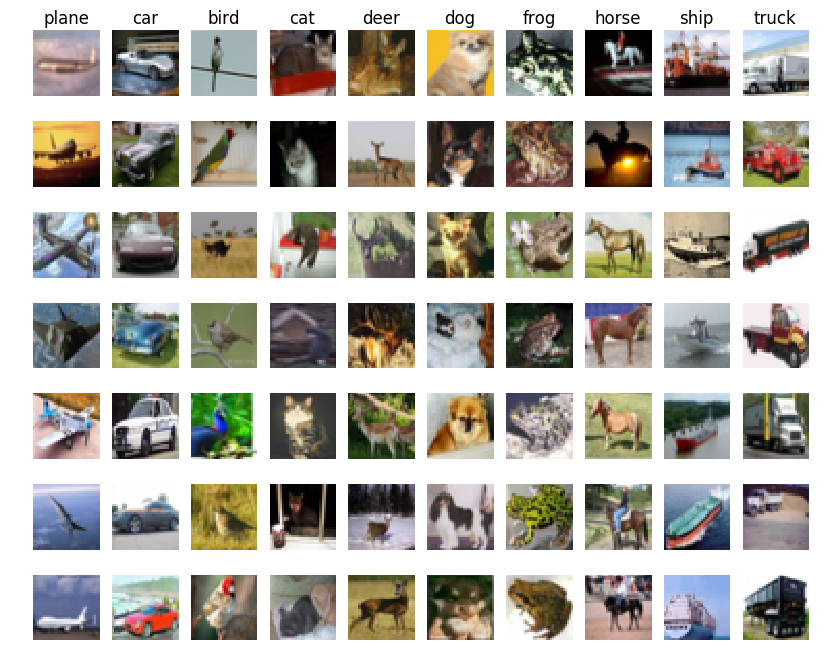

In [107]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes) # 10
samples_per_class = 7

for y, cls in enumerate(classes): 
# 첫번째 for loop에서는 각 column 당 7개의 랜덤한 이미지를 뿌려주는 역할
# classes라는 리스트를 10번 반복 # y는 0~9 # cls 는 plane, car, ... truck
    
    idxs = np.flatnonzero(y_train == y)     
    # flatnonzero() : 0이 아닌 원소들의 인덱스를 반환
    # 레이블이 0인 5,000개의 인덱스를 저장 -> 레이블이 1인 5,000개의 인덱스 저장 .... (반복))

#     print len(idxs)     # 5,000
#     print idxs.shape     # (5,000,)

    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    # rank-1 인 idxs (5,000개) 로부터 samples_per_class의 갯수 즉 7개를 랜덤하게 뽑는다. replace=False니까 중복 없이 뽑는다. 

#     print len(idxs)     # 7
#     print idxs.shape     # (7,)
#     print idxs     # [48643 42945 33996 11835 48852 46277 43012] # 각각의 이미지들의 인덱스 번호
    
    for i, idx in enumerate(idxs):
    # 두번째 for loop에서는 각 row당 10개의 이미지를 뿌려주는 역할
    # 7번 반복
        
        plt_idx = i * num_classes + y + 1     
        # subplot() 에서 위치 지정해 주기 위해서 plt_idx 계산 (1->11...->61 -> 2->12...->62 -> ... 10->20...->100)
        
        plt.subplot(samples_per_class, num_classes, plt_idx)     
        # subplot(7,10,1) -> subplot(7,10,11)...-> subplot(7,10,61) -> subplot(7,10,2) ... -> subplot(7,10,100)
        
        plt.imshow(X_train[idx].astype('uint8'))
        
        plt.axis('off')
        # X축/Y축을 없애 준다. 이 문장 없으면 각각의 subplot 마다 X축/Y축이 지저분하게 보이게 된다. 
        
        if i == 0:
            plt.title(cls)
            # 처음 (맨 윗줄) 에만 해당 클래스의 이름을 적어준다 
plt.show()

## 테스트의 편의를 위해 데이터를 축소해 주자

In [108]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000

mask = range(num_training)
# mask 는 list
# print len(mask)     # 5000
# print mask    # [0, 1, 2, ... , 4999]

X_train = X_train[mask]
# print X_train.shape     # (5000, 32, 32, 3)
# print X_train.size     # 15360000

y_train = y_train[mask]
# print y_train.shape     # (5000,)

num_test = 500
mask = range(num_test)

X_test = X_test[mask]
# print X_test.shape     # (500, 32, 32, 3)

y_test = y_test[mask]
# print y_test.shape     # (500,)

## 데이터를 가공해 주자
Vectorized 연산을 하기 위해 현재 rank4인 X_train과 X_test를 rank2로 만들어 준다. 
    * X_train : (5000x3072)
    * X_test : (500x3072)

In [109]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print X_train.shape, X_test.shape     
# (5000, 3072) (500, 3072)     # 3072 = 32 x 32 x 3   # 끝의 -1은 나머지를 모두 곱함

# reshape() 예제
# Y = np.ones((3,4,5,6))
# print Y.shape     # (3, 4, 5, 6)
# Y2 = np.reshape(Y, (Y.shape[0],-1))
# print Y2.shape     # (3, 120)

(5000, 3072) (500, 3072)


## classifier 가져와서 학습시켜주자
학습은 그저 변수에 할당하기만 하면 간단하게 끝난다. *(cs231n/classifiers/k_nearest_neighbor.py)*
    * self.X_train = X
    * self.y_train = y

In [110]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop:     # noop = no operation
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

## 이제 test example을 입력하여 distance를 구해 주자 - 1) Two Loops 방법을 이용해 구한다
실행에 꽤 시간이 걸리므로 기다려야 한다. (약 47초)

In [111]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

(500, 5000)


#### compute_distances_two_loops() 함수에서 dists 구하는 두가지 방법
    * dists[i,j] = np.sqrt( np.sum((X[i] - self.X_train[j])**2) )
    * dists[i,j] = np.linalg.norm(X[i] - self.X_train[j])

## distance를 도식화해보자

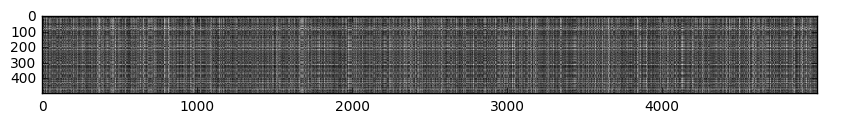

In [112]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
# 500 x 5000 으로 나타나게 된다
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



## NN (k=1) 을 돌리고 accuracy를 확인한다

In [113]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)
# print y_test_pred.shape # (500,)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

## kNN (k=5) 을 돌리고 accuracy를 확인한다

In [114]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 142 / 500 correct => accuracy: 0.284000


You should expect to see a slightly better performance than with `k = 1`.

## distance를 구해 주자 - 2) Partial Vectorization with One Loop 방법을 이용해 구한다
그리고 앞에서 Two loop으로 구한 dists와 방금 one loop으로 구한 dist_one 이 같은지 확인한다. 

In [115]:
# 소요시간 약 56초니까 기다려라
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


## distance를 구해 주자 - 3) Full Vectorization (No Loops) 방법을 이용해 구한다
그리고 앞에서 Two loop으로 구한 dists와 방금 no loop으로 구한 dist_two 가 같은지 확인한다. 

In [116]:
# 소요시간 1초 미만!!!
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


## Distance 구한 세가지 방법의 소요 시간을 비교해서 보자

In [117]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args) # 함수 호출
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 36.578072 seconds
One loop version took 55.523575 seconds
No loop version took 0.594191 seconds


## Cross Validation을 통해 최적의 k (hyperparameter) 를 구하자

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [118]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# np.array_split(리스트, 갯수) - 리스트를 갯수만큼으로 분산해 준다
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# print X_train.shape, y_train.shape, np.array(X_train_folds).shape, np.array(y_train_folds).shape
# (5000, 3072) (5000,) (5, 1000, 3072) (5, 1000)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    k_to_accuracies[k] = []

for k in k_choices:
    print 'evaluating k=%d' % k
    for j in range(num_folds):
        X_train_cv = np.vstack(X_train_folds[0:j]+X_train_folds[j+1:]) # 첫번째 loop의 X의 training은 1,2,3,4에서 한다
        # print X_train_cv.shape
        # (4000,3072) # (1000,3072) 4개를 수직으로 쌓았으니까 (4000, 3072)가 된다.
        
        X_test_cv = X_train_folds[j] # 첫번째 loop의 X의 test는 0에서 한다
        # print X_test_cv.shape
        # (1000,3072)
        
        # print len(y_train_folds), y_train_folds[0].shape
        # 5 (1000,)
        
        y_train_cv = np.hstack(y_train_folds[0:j]+y_train_folds[j+1:]) # 첫번째 loop의 y의 training은 1,2,3,4에서 한다
        # print y_train_cv.shape
        # (4000,) # (1000,)을 4개를 수평으로 쌓았으니까 (4000)이 된다
        
        y_test_cv = y_train_folds[j] # 첫번째 loop의 y의 테스트는 0에서 한다 
        #print y_test_cv.shape
        # (1000,)
        
        #print 'Training data shape: ', X_train_cv.shape
        #print 'Training labels shape: ', y_train_cv.shape
        #print 'Test data shape: ', X_test_cv.shape
        #print 'Test labels shape: ', y_test_cv.shape
        
        classifier.train(X_train_cv, y_train_cv)
        dists_cv = classifier.compute_distances_no_loops(X_test_cv)
        #print 'predicting now'
        y_test_pred = classifier.predict_labels(dists_cv, k)
        num_correct = np.sum(y_test_pred == y_test_cv)
        accuracy = float(num_correct) / num_test
        
        k_to_accuracies[k].append(accuracy)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

evaluating k=1
evaluating k=3
evaluating k=5
evaluating k=8
evaluating k=10
evaluating k=12
evaluating k=15
evaluating k=20
evaluating k=50
evaluating k=100
k = 1, accuracy = 0.526000
k = 1, accuracy = 0.514000
k = 1, accuracy = 0.528000
k = 1, accuracy = 0.556000
k = 1, accuracy = 0.532000
k = 3, accuracy = 0.482000
k = 3, accuracy = 0.498000
k = 3, accuracy = 0.486000
k = 3, accuracy = 0.546000
k = 3, accuracy = 0.528000
k = 5, accuracy = 0.516000
k = 5, accuracy = 0.546000
k = 5, accuracy = 0.562000
k = 5, accuracy = 0.580000
k = 5, accuracy = 0.544000
k = 8, accuracy = 0.526000
k = 8, accuracy = 0.576000
k = 8, accuracy = 0.556000
k = 8, accuracy = 0.570000
k = 8, accuracy = 0.554000
k = 10, accuracy = 0.530000
k = 10, accuracy = 0.592000
k = 10, accuracy = 0.556000
k = 10, accuracy = 0.568000
k = 10, accuracy = 0.572000
k = 12, accuracy = 0.520000
k = 12, accuracy = 0.588000
k = 12, accuracy = 0.562000
k = 12, accuracy = 0.564000
k = 12, accuracy = 0.562000
k = 15, accuracy = 0.51

## 각각의 k의 accuracy 를 도식화 해보자

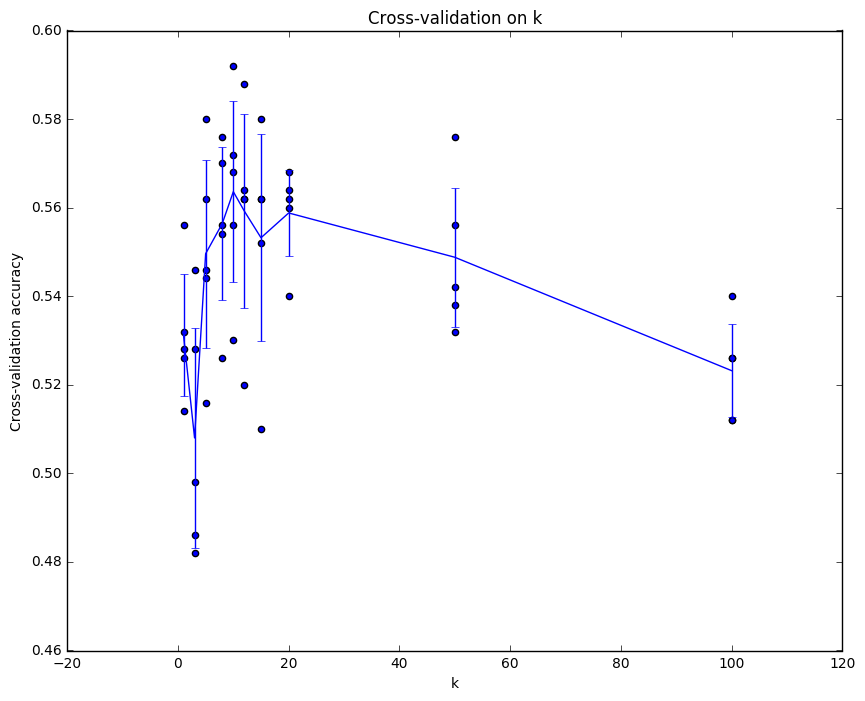

In [123]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    # print len(accuracies) # 5
    # print [k] # [1] [3] [5] [8] [10] [12] [15] [20] [50] [100]
    # print k_to_accuracies
    # {1: [0.526, 0.514, 0.528, 0.556, 0.532], 3: [0.482, 0.498, 0.486, 0.546, 0.528], 100: [0.512, 0.54, 0.526, 0.512, 0.526], 5: [0.516, 0.546, 0.562, 0.58, 0.544], 8: [0.526, 0.576, 0.556, 0.57, 0.554], 10: [0.53, 0.592, 0.556, 0.568, 0.572], 12: [0.52, 0.588, 0.562, 0.564, 0.562], 15: [0.51, 0.58, 0.562, 0.562, 0.552], 50: [0.542, 0.576, 0.556, 0.538, 0.532], 20: [0.54, 0.562, 0.56, 0.564, 0.568]}
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())]) # k=key, v=value 여기서는 v만 활용
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())]) # k=key, v=value 여기서는 v만 활용

plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')

## 최적의 k를 선정하고 이때의 accuracy를 출력한다

In [124]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
# best_k = 1
best_k = 7

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 141 / 500 correct => accuracy: 0.282000
